In [1]:
# Apply ML model to predict AQI values for 2021
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aqi as aqi
import joblib

In [2]:
# Read all individual 2021 data files per each quarter
df_2021_Q1 = pd.read_csv('/Users/nkichili/Desktop/Synopsys/waqi-covid19-airqualitydata-2021Q1.csv')
df_2021_Q2 = pd.read_csv('/Users/nkichili/Desktop/Synopsys/waqi-covid19-airqualitydata-2021Q2.csv')
df_2021_Q3 = pd.read_csv('/Users/nkichili/Desktop/Synopsys/waqi-covid19-airqualitydata-2021Q3.csv')
df_2021_Q4 = pd.read_csv('/Users/nkichili/Desktop/Synopsys/waqi-covid19-airqualitydata-2021Q4.csv')

In [3]:
# This current analysis considers only USA as other countries in the data set don't have required pollutant attributes
# USA data set doesn't come up with AQI (Air Quality Index) which needs to be calculated later (mentioned below)
df_2021_Q1_USA = df_2021_Q1.loc[df_2021_Q1['Country'] == 'US']
df_2021_Q2_USA = df_2021_Q2.loc[df_2021_Q2['Country'] == 'US']
df_2021_Q3_USA = df_2021_Q3.loc[df_2021_Q3['Country'] == 'US']
df_2021_Q4_USA = df_2021_Q4.loc[df_2021_Q4['Country'] == 'US']

In [4]:
# Choose only the required columns as we don't need count (samples), min, max, variance. 
cols = ['Date','Country','City','Specie','median']
df_2021_Q1_USA_5 = df_2021_Q1_USA[cols]
df_2021_Q2_USA_5 = df_2021_Q2_USA[cols]
df_2021_Q3_USA_5 = df_2021_Q3_USA[cols]
df_2021_Q4_USA_5 = df_2021_Q4_USA[cols]

In [5]:
# The original data set contains each pollutant by date, city, country in each row which is hard to perform analysis
# Use Pivot to transponse long to wide format so that each row will have Date, Country, City, other polluntant attributes, value
df_2021_Q1_USA_PV = df_2021_Q1_USA_5.pivot(index=['Date','Country','City'], columns='Specie', values='median').reset_index()
df_2021_Q2_USA_PV = df_2021_Q2_USA_5.pivot(index=['Date','Country','City'], columns='Specie', values='median').reset_index()
df_2021_Q3_USA_PV = df_2021_Q3_USA_5.pivot(index=['Date','Country','City'], columns='Specie', values='median').reset_index()
df_2021_Q4_USA_PV = df_2021_Q4_USA_5.pivot(index=['Date','Country','City'], columns='Specie', values='median').reset_index()


In [6]:
# A sample of columns listed below based on the above step execution
df_2021_Q1_USA_PV.columns

Index(['Date', 'Country', 'City', 'co', 'dew', 'humidity', 'no2', 'o3', 'pm10',
       'pm25', 'precipitation', 'pressure', 'so2', 'temperature', 'wd',
       'wind-gust', 'wind-speed'],
      dtype='object', name='Specie')

In [7]:
# Air Quality Index (AQI) requires one of pm10 or pm25 and at least total 3 attributes from CO, NO2, O3, PM10, PM25, SO2
# Reference: https://app.cpcbccr.com/ccr_docs/How_AQI_Calculated.pdf
# Refer page#14 in https://www.airnow.gov/sites/default/files/2021-05/aqi-technical-assistance-document-sept2018.pdf

df_2021_Q1_USA_POLLUTANT = df_2021_Q1_USA_PV[['Date','Country','City', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2']]
df_2021_Q2_USA_POLLUTANT = df_2021_Q2_USA_PV[['Date','Country','City', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2']]
df_2021_Q3_USA_POLLUTANT = df_2021_Q3_USA_PV[['Date','Country','City', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2']]
df_2021_Q4_USA_POLLUTANT = df_2021_Q4_USA_PV[['Date','Country','City', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2']]


In [8]:
# Combine all quarters of 2021 data set
df_2021_USA_FINAL = df_2021_Q1_USA_POLLUTANT.append([df_2021_Q2_USA_POLLUTANT, df_2021_Q3_USA_POLLUTANT, df_2021_Q4_USA_POLLUTANT])
df_2021_USA_FINAL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20406 entries, 0 to 4134
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     20406 non-null  object 
 1   Country  20406 non-null  object 
 2   City     20406 non-null  object 
 3   co       15654 non-null  float64
 4   no2      15664 non-null  float64
 5   o3       19460 non-null  float64
 6   pm10     10038 non-null  float64
 7   pm25     20318 non-null  float64
 8   so2      8844 non-null   float64
dtypes: float64(6), object(3)
memory usage: 1.6+ MB


In [9]:
# The above info shows that there are lot of missing values for pollutants (Eg: Out of 20406 entries, pm25 has values for 20318 only)
df_2021_USA_FINAL.head(5)

Specie,Date,Country,City,co,no2,o3,pm10,pm25,so2
0,2020-12-28,US,Albuquerque,1.5,5.6,22.4,22.0,20.0,1.5
1,2020-12-28,US,Atlanta,5.2,16.0,11.2,18.0,53.0,0.3
2,2020-12-28,US,Austin,NaN,2.9,18.4,NaN,25.0,NaN
3,2020-12-28,US,Baltimore,NaN,15.8,16.8,11.0,38.0,NaN
4,2020-12-28,US,Boise,2.5,10.2,12.8,15.0,42.0,0.3


<AxesSubplot:xlabel='Specie'>

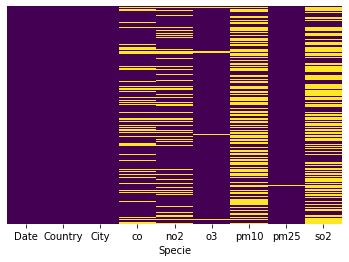

In [10]:
# The below heatmap shows missing values (yellow color) for different pollutants
sns.heatmap(df_2021_USA_FINAL.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [11]:
# Fill the missing values of pollutants by taking mean of that pollutant for that country and city
df_2021_USA_FINAL['pm10'] = df_2021_USA_FINAL.groupby(["Country", "City"])['pm10'].transform(lambda x: x.fillna(x.mean()))
df_2021_USA_FINAL['pm25'] = df_2021_USA_FINAL.groupby(["Country", "City"])['pm25'].transform(lambda x: x.fillna(x.mean()))
df_2021_USA_FINAL['no2'] = df_2021_USA_FINAL.groupby(["Country", "City"])['no2'].transform(lambda x: x.fillna(x.mean()))
df_2021_USA_FINAL['so2'] = df_2021_USA_FINAL.groupby(["Country", "City"])['so2'].transform(lambda x: x.fillna(x.mean()))
df_2021_USA_FINAL['co'] = df_2021_USA_FINAL.groupby(["Country", "City"])['co'].transform(lambda x: x.fillna(x.mean()))
df_2021_USA_FINAL['o3'] = df_2021_USA_FINAL.groupby(["Country", "City"])['o3'].transform(lambda x: x.fillna(x.mean()))

df_2021_USA_FINAL.columns

Index(['Date', 'Country', 'City', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2'], dtype='object', name='Specie')

<AxesSubplot:xlabel='Specie'>

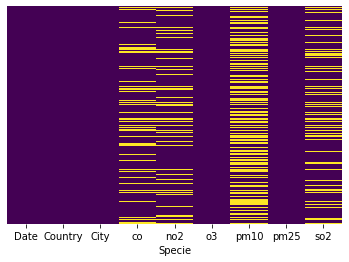

In [12]:
# After filling the missing values with mean of the specific pollutant as stated above, this heatmap still shows some missing values
sns.heatmap(df_2021_USA_FINAL.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [13]:
#Before applying mean for missing values, so2 had values for 8844 entries only but after applying mean, so2 has values for 15228
df_2021_USA_FINAL.info()
df_2021_USA_FINAL.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20406 entries, 0 to 4134
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     20406 non-null  object 
 1   Country  20406 non-null  object 
 2   City     20406 non-null  object 
 3   co       16338 non-null  float64
 4   no2      16708 non-null  float64
 5   o3       20406 non-null  float64
 6   pm10     10794 non-null  float64
 7   pm25     20406 non-null  float64
 8   so2      15228 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.6+ MB


Specie,Date,Country,City,co,no2,o3,pm10,pm25,so2
0,2020-12-28,US,Albuquerque,1.5,5.6,22.4,22.0,20.0,1.500000
1,2020-12-28,US,Atlanta,5.2,16.0,11.2,18.0,53.0,0.300000
2,2020-12-28,US,Austin,NaN,2.9,18.4,NaN,25.0,0.492949
3,2020-12-28,US,Baltimore,NaN,15.8,16.8,11.0,38.0,1.918519
4,2020-12-28,US,Boise,2.5,10.2,12.8,15.0,42.0,0.300000


In [14]:
# This time, fill the missing value of mean of a particular pollutant based on all rows of that column instead of restricting with specific cities
df_2021_USA_FINAL['pm10'] = df_2021_USA_FINAL['pm10'].fillna(df_2021_USA_FINAL['pm10'].mean())
df_2021_USA_FINAL['pm25'] = df_2021_USA_FINAL['pm25'].fillna(df_2021_USA_FINAL['pm25'].mean())
df_2021_USA_FINAL['no2'] = df_2021_USA_FINAL['no2'].fillna(df_2021_USA_FINAL['no2'].mean())
df_2021_USA_FINAL['so2'] = df_2021_USA_FINAL['so2'].fillna(df_2021_USA_FINAL['so2'].mean())
df_2021_USA_FINAL['co'] = df_2021_USA_FINAL['co'].fillna(df_2021_USA_FINAL['co'].mean())
df_2021_USA_FINAL['o3'] = df_2021_USA_FINAL['o3'].fillna(df_2021_USA_FINAL['o3'].mean())
df_2021_USA_FINAL

Specie,Date,Country,City,co,no2,o3,pm10,pm25,so2
0,2020-12-28,US,Albuquerque,1.500000,5.600000,22.4,22.000000,20.0,1.500000
1,2020-12-28,US,Atlanta,5.200000,16.000000,11.2,18.000000,53.0,0.300000
2,2020-12-28,US,Austin,2.865217,2.900000,18.4,18.476567,25.0,0.492949
3,2020-12-28,US,Baltimore,2.865217,15.800000,16.8,11.000000,38.0,1.918519
4,2020-12-28,US,Boise,2.500000,10.200000,12.8,15.000000,42.0,0.300000
...,...,...,...,...,...,...,...,...,...
4130,2022-01-01,US,Staten Island,4.500000,11.200000,4.8,18.476567,30.0,1.510332
4131,2022-01-01,US,Tallahassee,0.700000,7.646576,9.4,13.000000,24.0,0.100000
4132,2022-01-01,US,The Bronx,3.800000,19.100000,6.4,18.476567,41.0,1.307595
4133,2022-01-01,US,Tucson,1.958163,5.692893,28.1,6.000000,17.0,0.220468


<AxesSubplot:xlabel='Specie'>

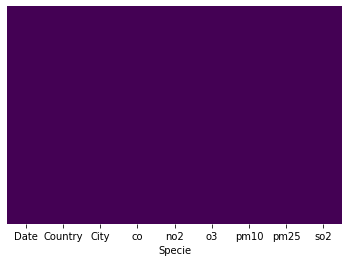

In [15]:
# WIth the above fill of missing values, now the heatmap doesn't show any yellow spots. So, there are no missing values in the data set now
sns.heatmap(df_2021_USA_FINAL.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [16]:
# This shows all pollutants have values as it matches total number of entries (22031)
df_2021_USA_FINAL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20406 entries, 0 to 4134
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     20406 non-null  object 
 1   Country  20406 non-null  object 
 2   City     20406 non-null  object 
 3   co       20406 non-null  float64
 4   no2      20406 non-null  float64
 5   o3       20406 non-null  float64
 6   pm10     20406 non-null  float64
 7   pm25     20406 non-null  float64
 8   so2      20406 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.6+ MB


<AxesSubplot:xlabel='City'>

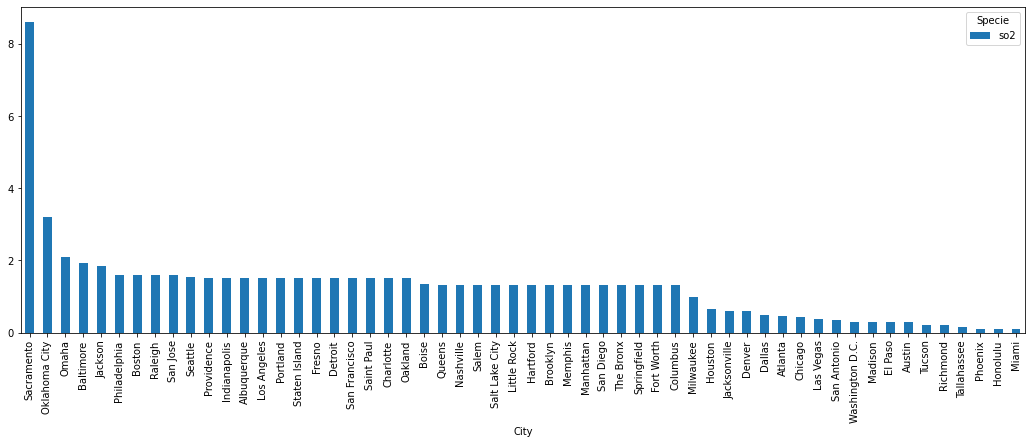

In [17]:
df_2021_USA_FINAL[['so2', 'City']].groupby(['City']).median().sort_values("so2", ascending = False).plot.bar(figsize=(18,6))


<AxesSubplot:xlabel='City'>

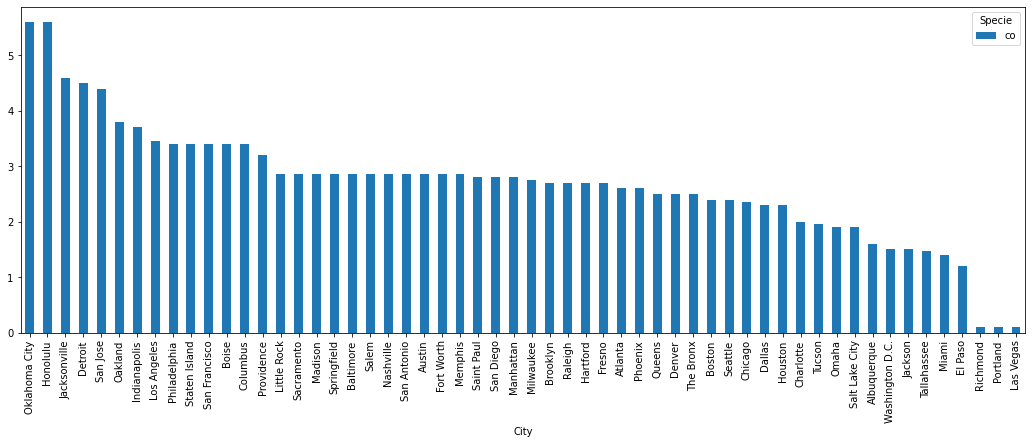

In [18]:
df_2021_USA_FINAL[['co', 'City']].groupby(['City']).median().sort_values("co", ascending = False).plot.bar(figsize=(18,6))


<AxesSubplot:xlabel='City'>

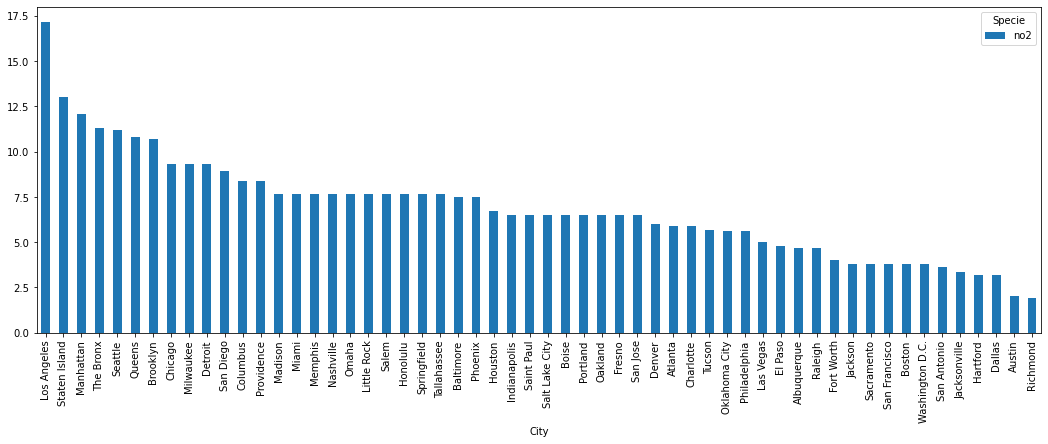

In [19]:
df_2021_USA_FINAL[['no2', 'City']].groupby(['City']).median().sort_values("no2", ascending = False).plot.bar(figsize=(18,6))


<AxesSubplot:xlabel='City'>

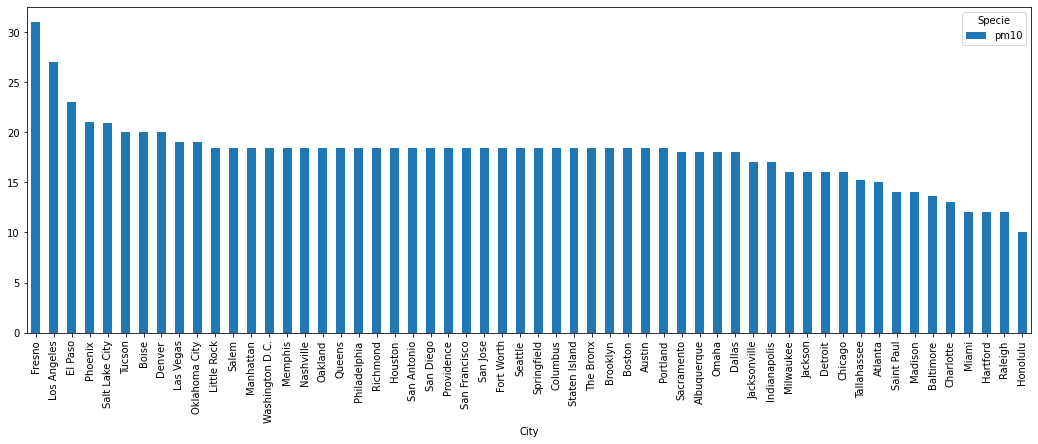

In [20]:
df_2021_USA_FINAL[['pm10', 'City']].groupby(['City']).median().sort_values("pm10", ascending = False).plot.bar(figsize=(18,6))


Distribution of different pollutants


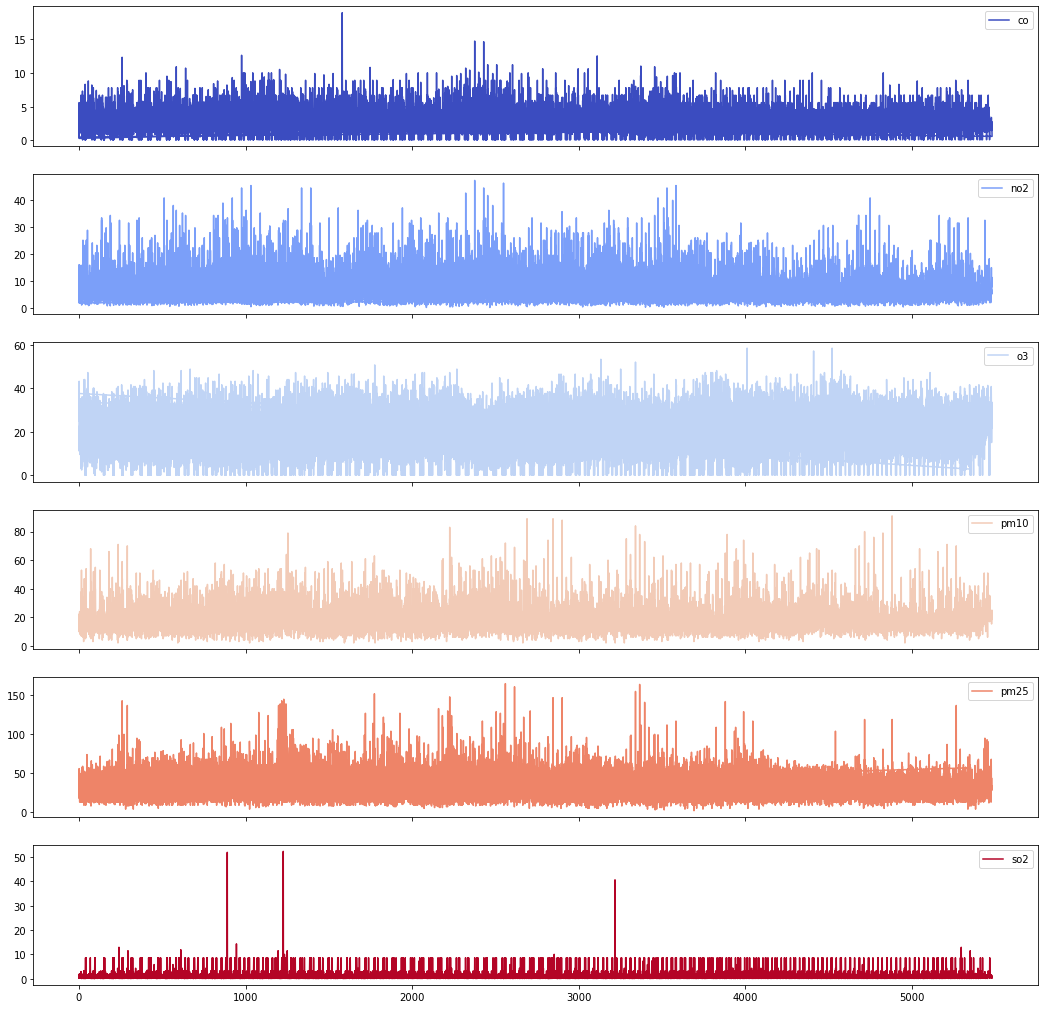

In [21]:
# This is just exploratory data analysis to plot pollutant in 2021
pollutants = ['co', 'no2', 'o3', 'pm10', 'pm25', 'so2']

df_2021_USA_FINAL_PLT = df_2021_USA_FINAL[pollutants]

print('Distribution of different pollutants')
df_2021_USA_FINAL_PLT.plot(kind='line',figsize=(18,18),cmap='coolwarm',subplots=True,fontsize=10);


<AxesSubplot:xlabel='Specie', ylabel='Specie'>

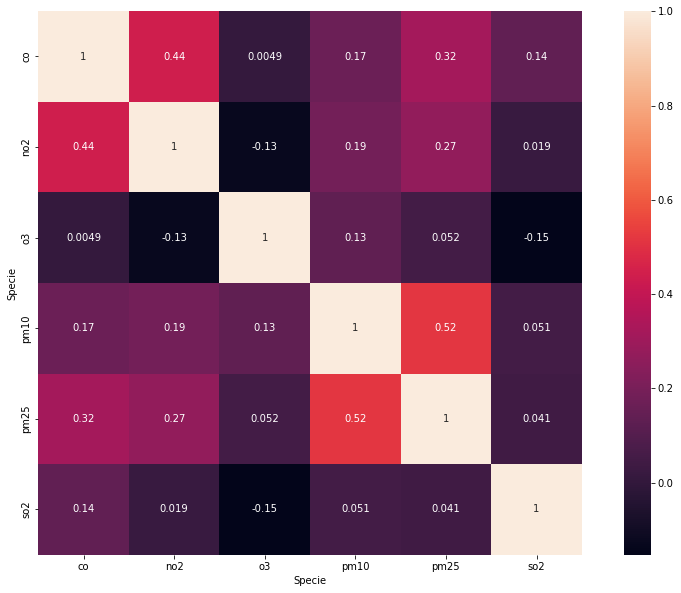

In [22]:
corrmat = df_2021_USA_FINAL[pollutants].corr()
f, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(corrmat, vmax = 1, square = True, annot = True)

In [23]:
def top_and_bottom_10_states(indicator="so2"):
    fig, ax = plt.subplots(2,1, figsize=(20, 12))
    
    ind = df_2021_USA_FINAL[[indicator, 'City']].groupby('City', as_index=False).median().sort_values(by=indicator,ascending=False)
    top10 = sns.barplot(x='City', y=indicator, data=ind[:10], ax=ax[0])
    top10.set_title("Top 10 states by {} (2021)".format(indicator))
    top10.set_ylabel(indicator)
    top10.set_xlabel("City")
    
    bottom10 = sns.barplot(x='City', y=indicator, data=ind[-10:], ax=ax[1])
    bottom10.set_title("Bottom 10 states by {} (2021)".format(indicator))
    bottom10.set_ylabel(indicator)
    bottom10.set_xlabel("City")

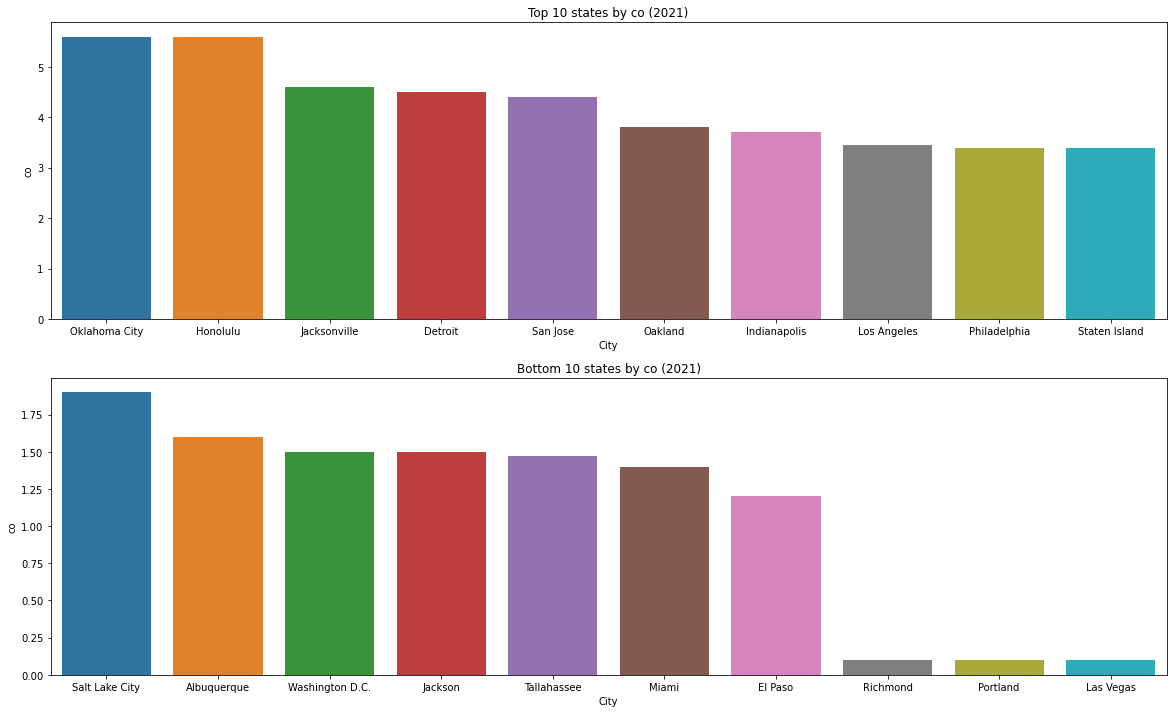

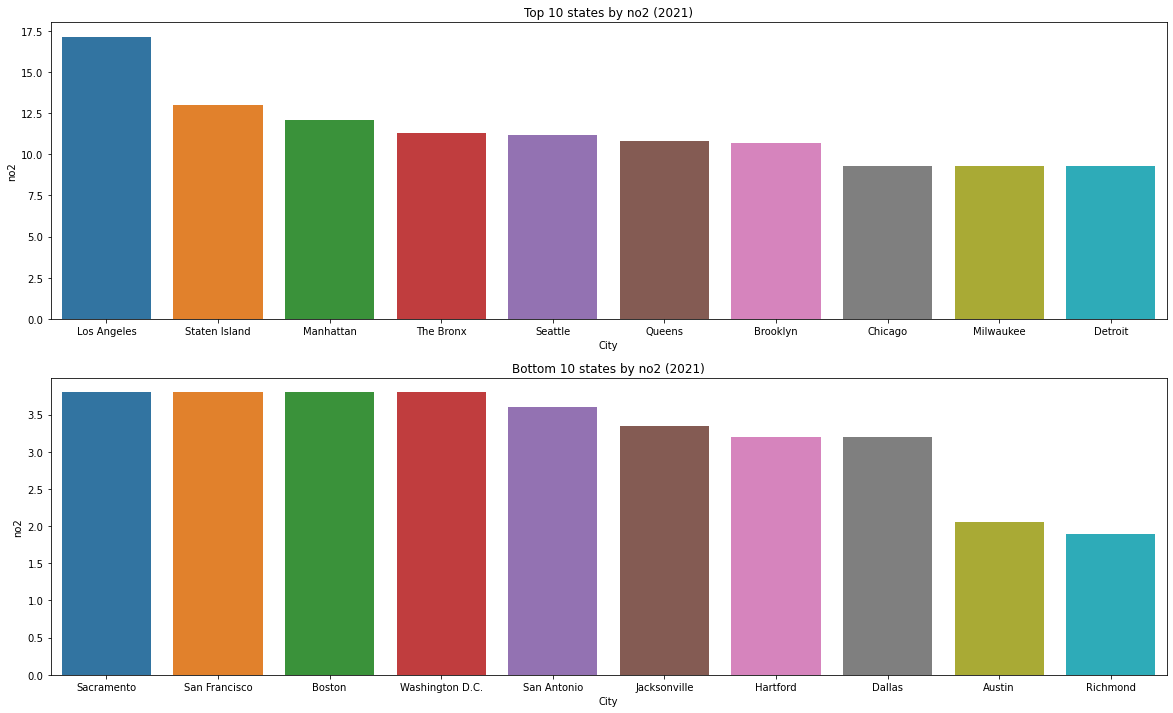

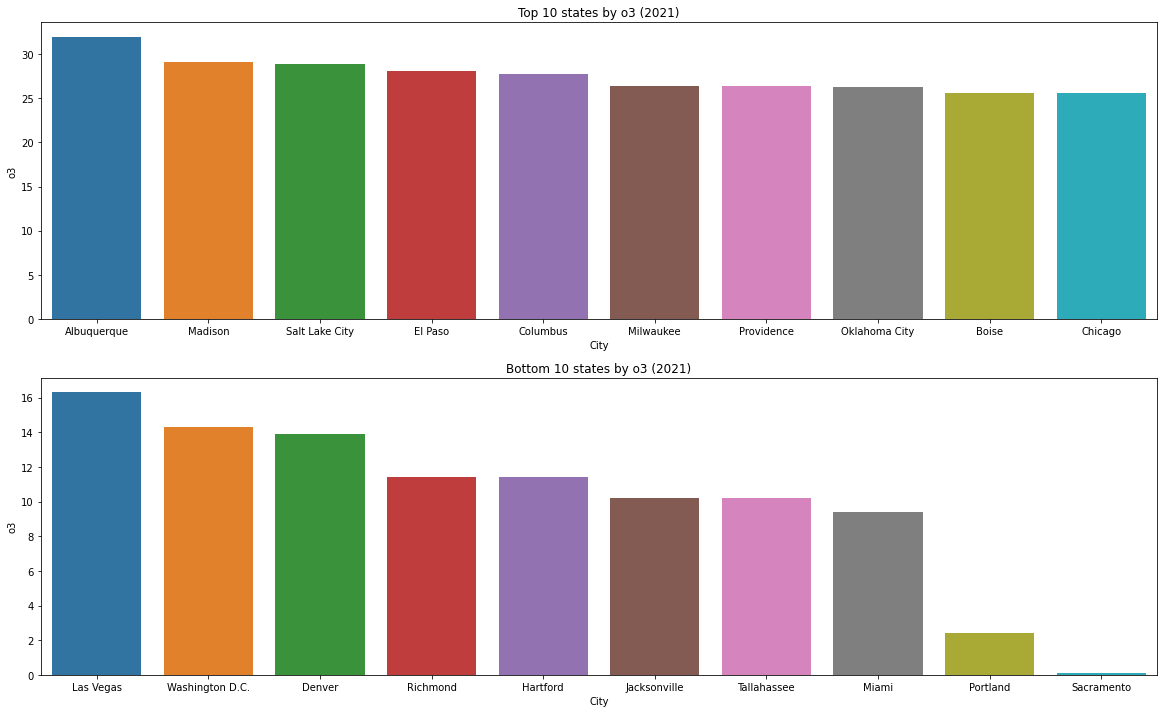

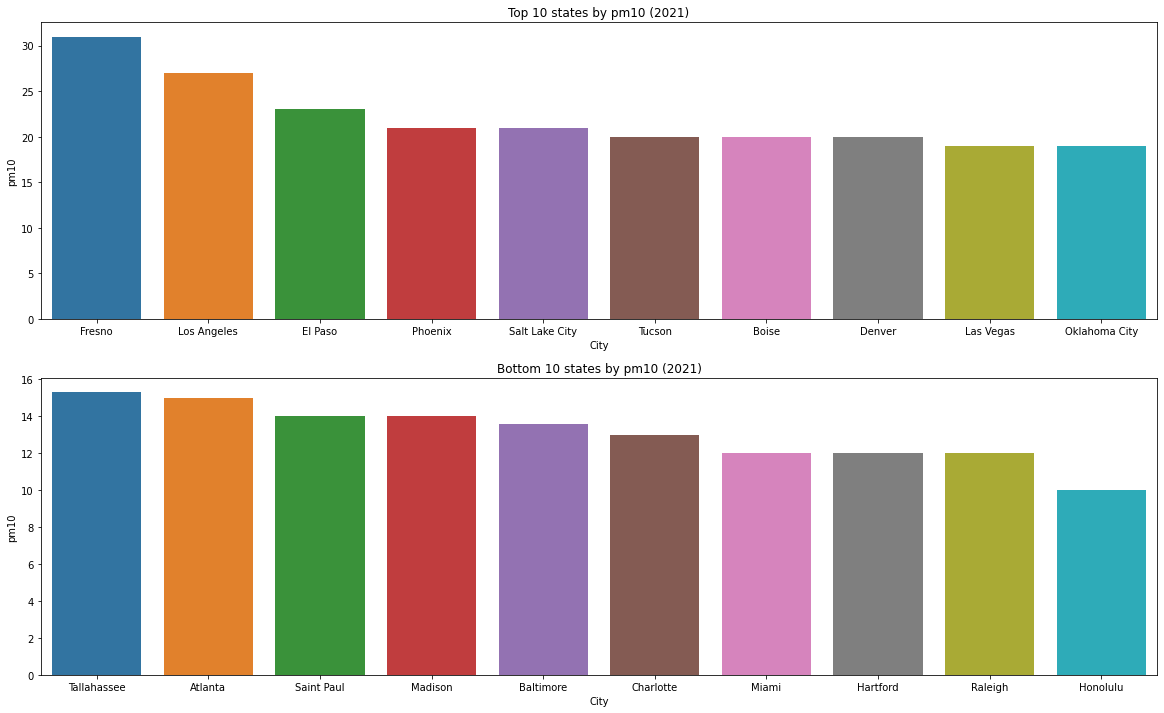

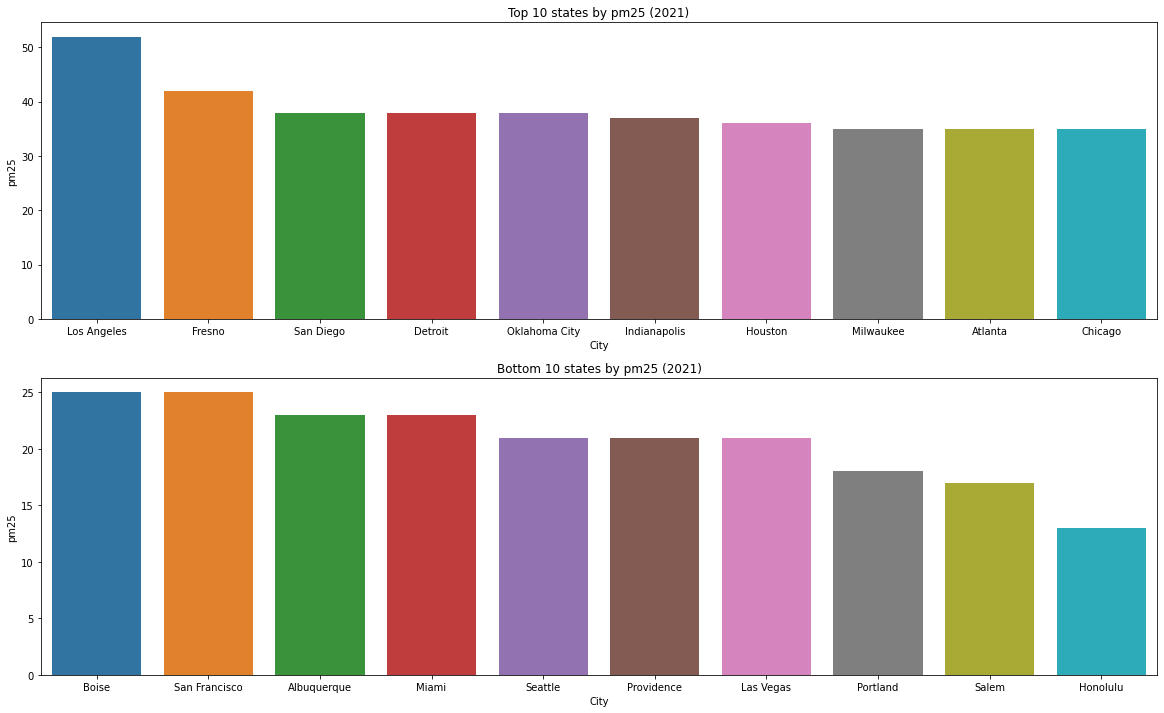

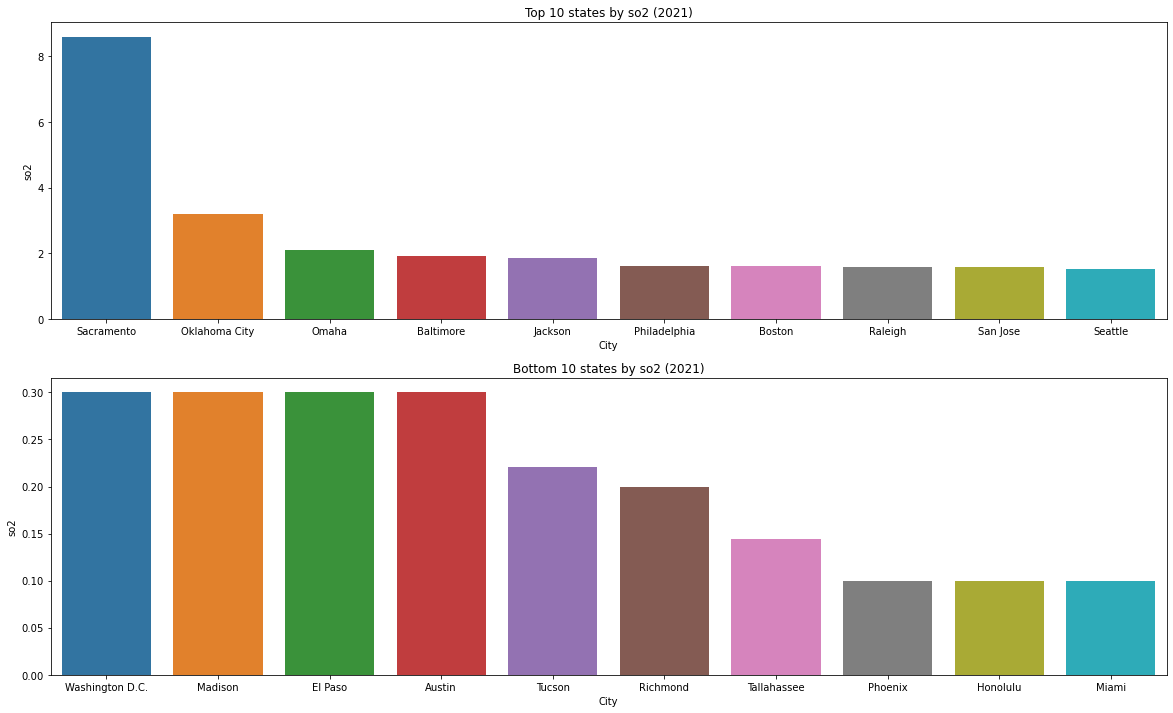

In [24]:
top_and_bottom_10_states("co")
top_and_bottom_10_states("no2")
top_and_bottom_10_states("o3")
top_and_bottom_10_states("pm10")
top_and_bottom_10_states("pm25")
top_and_bottom_10_states("so2")

In [25]:
# defining a function to find the highest ever recorded levels for a given indicator (defaults to SO2) by state
# sidenote: mostly outliers
def highest_levels_recorded(indicator="so2"):
    plt.figure(figsize=(20,10))
    ind = df_2021_USA_FINAL[[indicator, 'City', 'Date']].groupby('City', as_index=False).max()
    highest = sns.barplot(x='City', y=indicator, data=ind)
    highest.set_title("Highest ever {} levels recorded by City".format(indicator))
    plt.xticks(rotation=90)

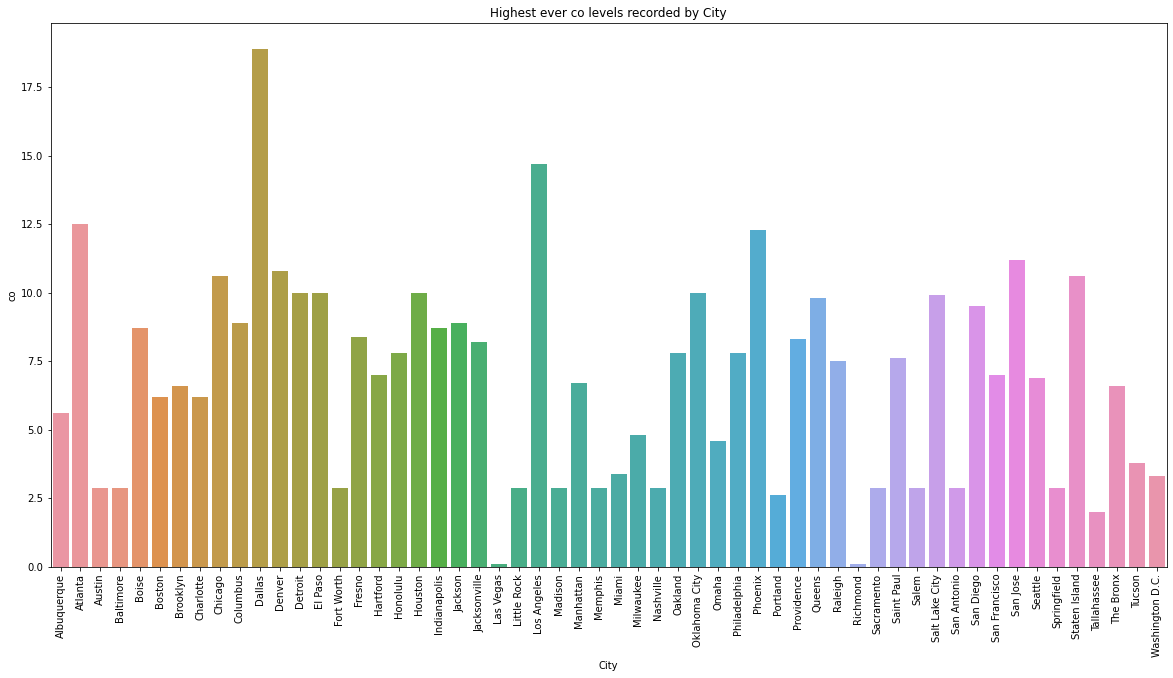

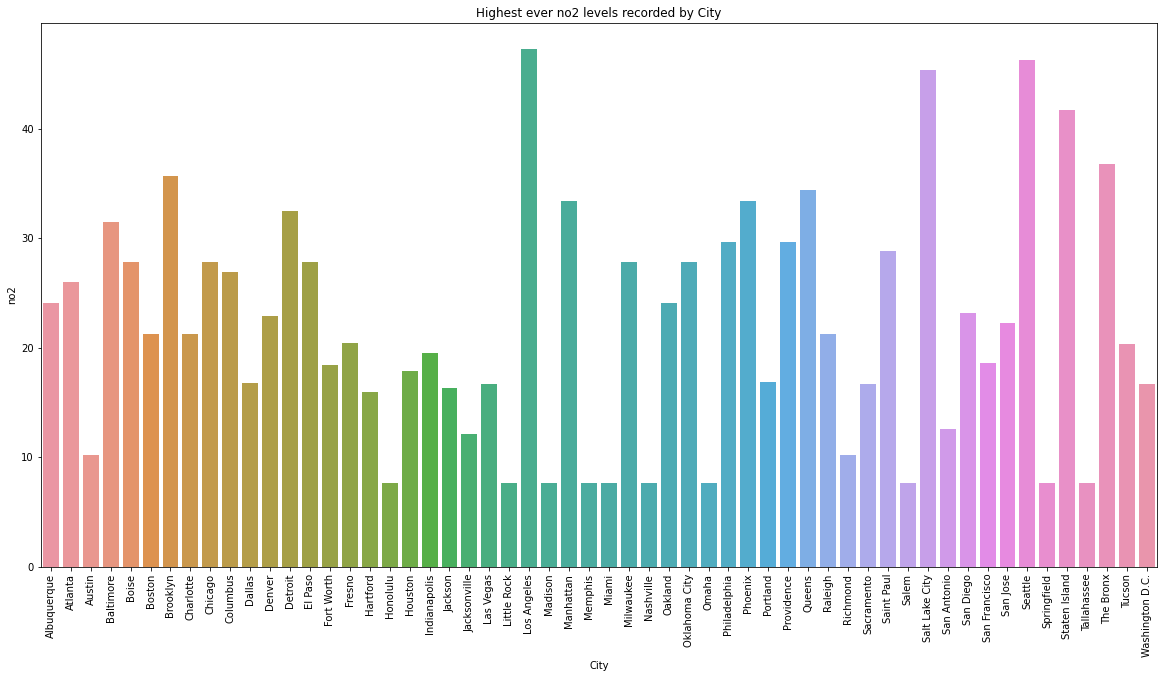

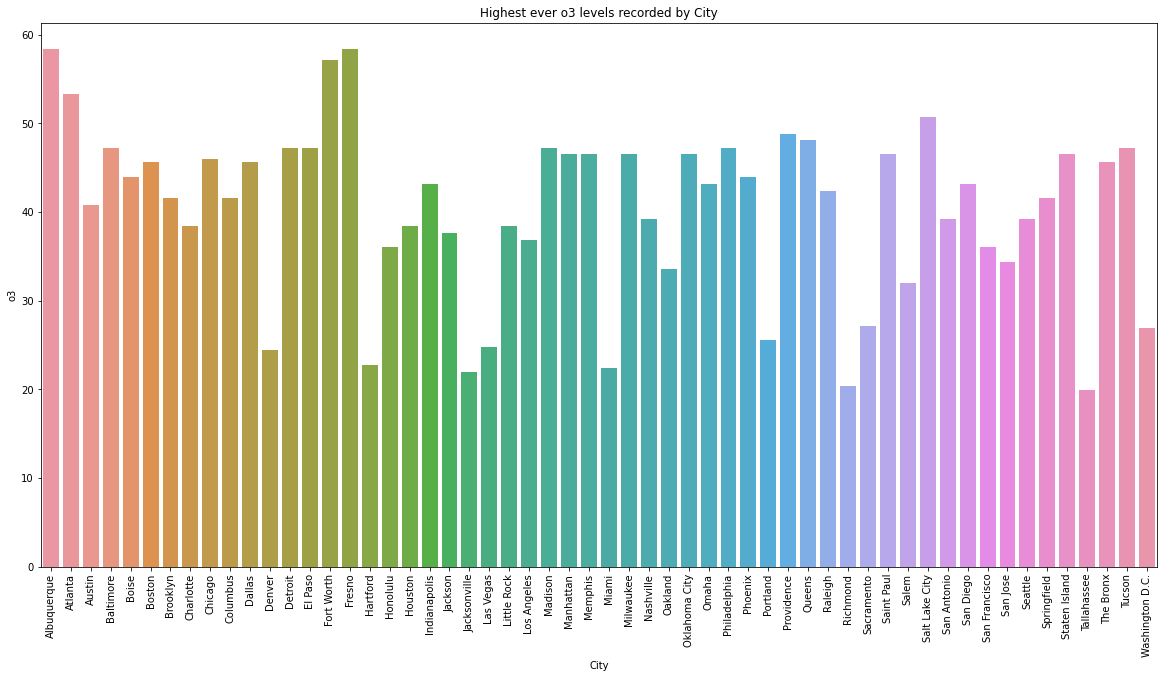

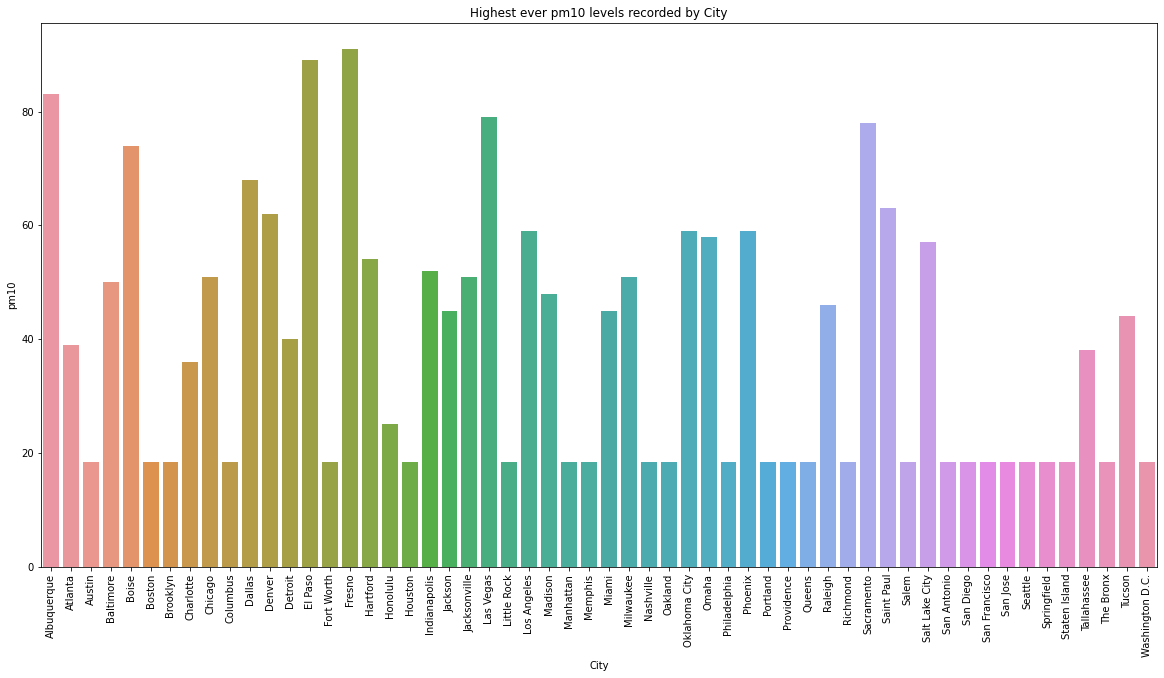

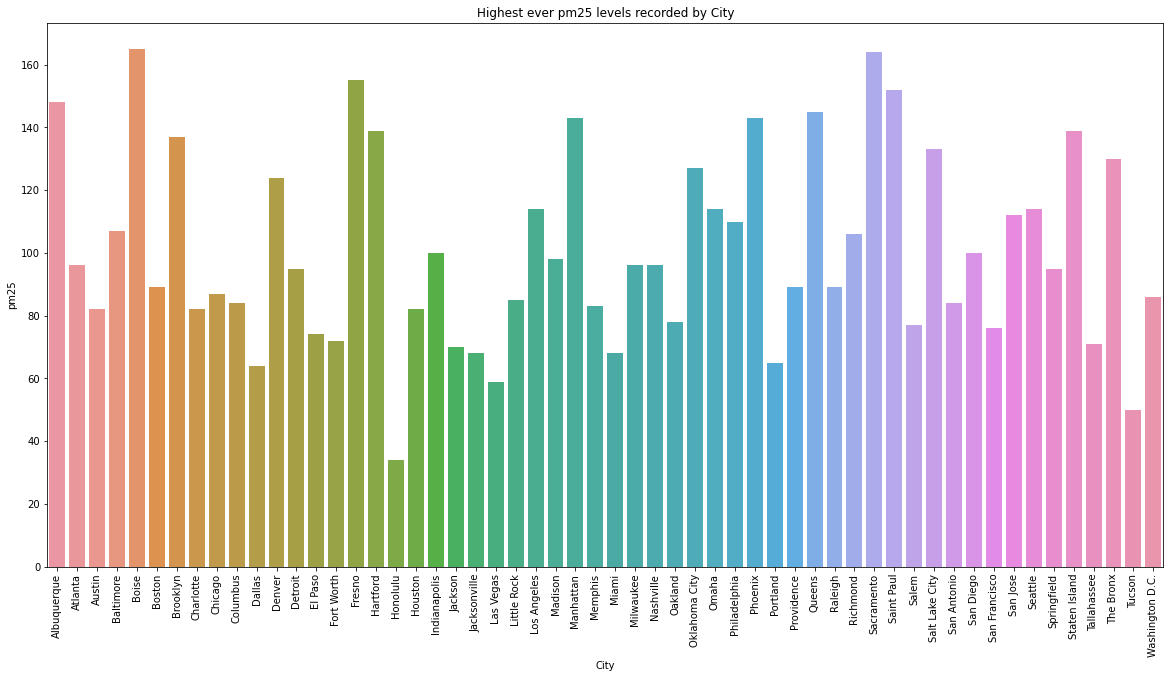

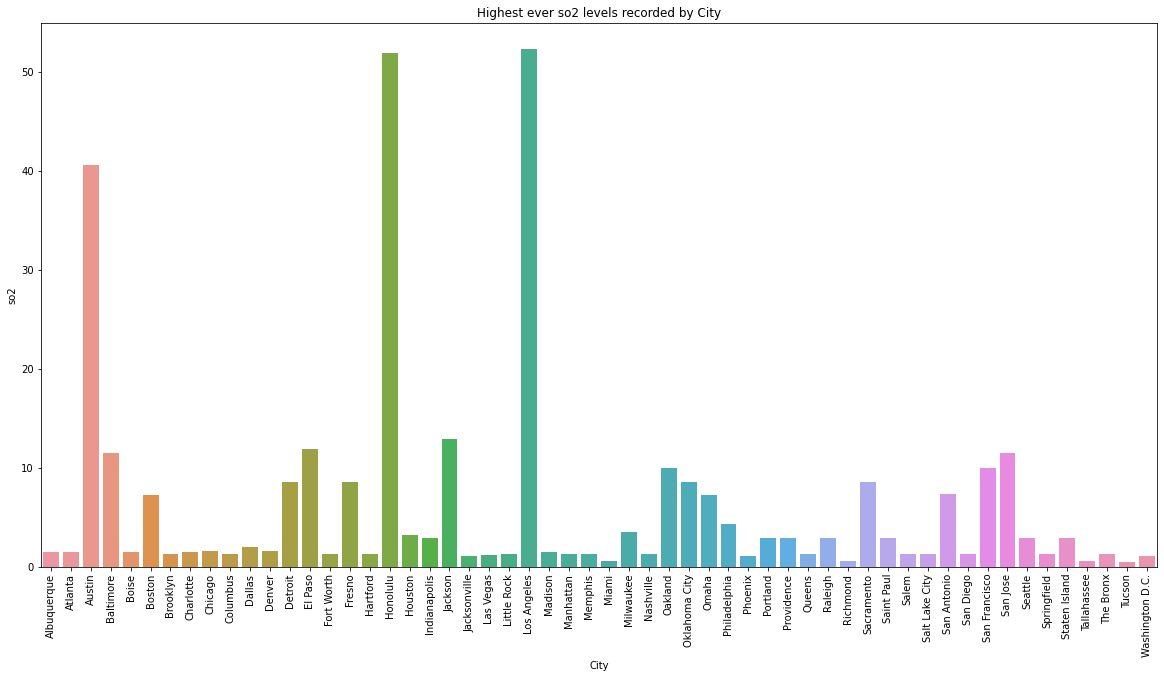

In [26]:
highest_levels_recorded("co")
highest_levels_recorded("no2")
highest_levels_recorded("o3")
highest_levels_recorded("pm10")
highest_levels_recorded("pm25")
highest_levels_recorded("so2")

In [27]:
# Perform sorting by Date, City, Country
df_2021_USA_FINAL.sort_values(by=['Date', 'City', 'Country'], ascending=False)
df_2021_USA_FINAL.head(5)

Specie,Date,Country,City,co,no2,o3,pm10,pm25,so2
0,2020-12-28,US,Albuquerque,1.500000,5.6,22.4,22.000000,20.0,1.500000
1,2020-12-28,US,Atlanta,5.200000,16.0,11.2,18.000000,53.0,0.300000
2,2020-12-28,US,Austin,2.865217,2.9,18.4,18.476567,25.0,0.492949
3,2020-12-28,US,Baltimore,2.865217,15.8,16.8,11.000000,38.0,1.918519
4,2020-12-28,US,Boise,2.500000,10.2,12.8,15.000000,42.0,0.300000


In [28]:
df_2021_USA_FINAL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20406 entries, 0 to 4134
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     20406 non-null  object 
 1   Country  20406 non-null  object 
 2   City     20406 non-null  object 
 3   co       20406 non-null  float64
 4   no2      20406 non-null  float64
 5   o3       20406 non-null  float64
 6   pm10     20406 non-null  float64
 7   pm25     20406 non-null  float64
 8   so2      20406 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.6+ MB


In [29]:
# Create a python function that takes necessary pollutant values and invoke the python-aqi package to perform AQI calculation
# and return the value for each row. Here, we are considering pm25, pm10, no2 and so2. As per AQI calculation requirement, 
# we should have at least either pm25 or pm10 and two other pollutant attributes since not all pollutants are always recorded.

def getaqi(pm25, pm10, no2, so2):
    #print(pm25, pm10, no2, so2)
    myaqi = aqi.to_aqi([
        (aqi.POLLUTANT_PM25, pm25),
        (aqi.POLLUTANT_PM10, pm10),
        (aqi.POLLUTANT_NO2_1H, no2),
        (aqi.POLLUTANT_SO2_1H, so2)
    ])
    #print(myaqi)
    return myaqi

In [30]:
# Because for one of the rows pm25 is 507, which is more than 500.4 set in python-aqi library

# Set min values for pm25, pm10, no2 ans so2 as defined in https://github.com/hrbonz/python-aqi/blob/master/aqi/algos/epa.py
df_2021_USA_FINAL.loc[df_2021_USA_FINAL['pm25'] < 0, 'pm25'] = 0
df_2021_USA_FINAL.loc[df_2021_USA_FINAL['pm10'] < 0, 'pm10'] = 0
df_2021_USA_FINAL.loc[df_2021_USA_FINAL['no2'] < 0, 'no2'] = 0
df_2021_USA_FINAL.loc[df_2021_USA_FINAL['so2'] < 0, 'so2'] = 0

# Set max values for pm25, pm10, no2 ans so2 as defined in https://github.com/hrbonz/python-aqi/blob/master/aqi/algos/epa.py
df_2021_USA_FINAL.loc[df_2021_USA_FINAL['pm25'] > 500.4, 'pm25'] = 500.4
df_2021_USA_FINAL.loc[df_2021_USA_FINAL['pm10'] > 604, 'pm10'] = 604
df_2021_USA_FINAL.loc[df_2021_USA_FINAL['no2'] > 2049, 'no2'] = 2049
df_2021_USA_FINAL.loc[df_2021_USA_FINAL['so2'] > 1004, 'so2'] = 1004

In [31]:
# Apply recursive lambda to call the above AQI function for each row to populate AQI value
df_2021_USA_FINAL["aqi"] = df_2021_USA_FINAL.apply(lambda row: getaqi(row['pm25'],
                                                                     row['pm10'],
                                                                     row['no2'],
                                                                     row['so2']), axis = 1)

In [32]:
# The above calls returns AQI value as an object but we need to conver this to numeric for further analysis
df_2021_USA_FINAL[['aqi']] = df_2021_USA_FINAL[['aqi']].apply(pd.to_numeric)

In [33]:
df_2021_USA_FINAL.head(5)

Specie,Date,Country,City,co,no2,o3,pm10,pm25,so2,aqi
0,2020-12-28,US,Albuquerque,1.500000,5.6,22.4,22.000000,20.0,1.500000,68.0
1,2020-12-28,US,Atlanta,5.200000,16.0,11.2,18.000000,53.0,0.300000,144.0
2,2020-12-28,US,Austin,2.865217,2.9,18.4,18.476567,25.0,0.492949,78.0
3,2020-12-28,US,Baltimore,2.865217,15.8,16.8,11.000000,38.0,1.918519,107.0
4,2020-12-28,US,Boise,2.500000,10.2,12.8,15.000000,42.0,0.300000,117.0


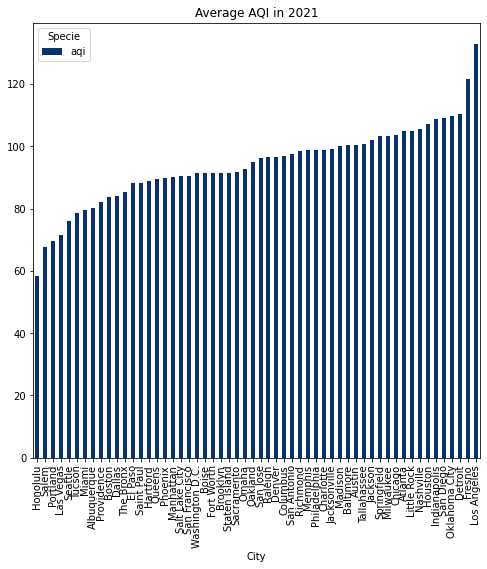

In [34]:
# Just a fun plot to see which city in USA is most polluted based on AQI value. Honolulu is healthy but LA is very bad
df_2021_USA_FINAL[['City','aqi']].groupby('City').mean().sort_values('aqi').plot(kind='bar',cmap='Blues_r',figsize=(8,8))
plt.title('Average AQI in 2021');

In [35]:
#Change the date column format from object to date
df_2021_USA_FINAL['Date'] = pd.to_datetime(df_2021_USA_FINAL['Date'])

#Split the date column in to day, moth and year for ML
df_2021_USA_FINAL['Year']= df_2021_USA_FINAL['Date'].dt.year
df_2021_USA_FINAL['Month']= df_2021_USA_FINAL['Date'].dt.month
df_2021_USA_FINAL['Day']= df_2021_USA_FINAL['Date'].dt.day
df_2021_USA_FINAL.drop('Date',1)

# Drop the date column
df_2021_final = df_2021_USA_FINAL.drop('Date',1)
rearranged_cols = ['Year','Month','Day','Country','City','co','no2','o3','pm10','pm25','aqi']
df_2021_final = df_2021_USA_FINAL [rearranged_cols]
df_2021_final.head(5)

/var/folders/dr/dd4yfyn51lxdhh0dqg_f3dvh0000gq/T/ipykernel_18817/307676570.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_2021_USA_FINAL.drop('Date',1)
/var/folders/dr/dd4yfyn51lxdhh0dqg_f3dvh0000gq/T/ipykernel_18817/307676570.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_2021_final = df_2021_USA_FINAL.drop('Date',1)


Specie,Year,Month,Day,Country,City,co,no2,o3,pm10,pm25,aqi
0,2020,12,28,US,Albuquerque,1.500000,5.6,22.4,22.000000,20.0,68.0
1,2020,12,28,US,Atlanta,5.200000,16.0,11.2,18.000000,53.0,144.0
2,2020,12,28,US,Austin,2.865217,2.9,18.4,18.476567,25.0,78.0
3,2020,12,28,US,Baltimore,2.865217,15.8,16.8,11.000000,38.0,107.0
4,2020,12,28,US,Boise,2.500000,10.2,12.8,15.000000,42.0,117.0


In [36]:
# Write the ML ready file to a CSV
df_2021_final.to_csv('/Users/nkichili/Desktop/Synopsys/aqi_for_ml_2021.csv', index=False)

In [37]:
df_2021_sortbyaqi = df_2021_final.sort_values(by=['aqi'], ascending=False)
df_2021_sortbyaqi.head(20)

Specie,Year,Month,Day,Country,City,co,no2,o3,pm10,pm25,aqi
2559,2021,8,14,US,Boise,7.800000,14.900000,25.6,72.000000,165.0,215.0
3365,2021,8,28,US,Sacramento,2.865217,6.500000,0.1,78.000000,164.0,214.0
2614,2021,8,15,US,Boise,7.500000,13.900000,22.4,69.000000,161.0,211.0
3340,2021,8,28,US,Fresno,8.000000,7.500000,52.0,84.000000,155.0,205.0
1773,2021,7,30,US,Saint Paul,6.600000,6.500000,24.1,63.000000,152.0,202.0
2225,2021,8,8,US,Albuquerque,3.600000,2.800000,47.2,83.000000,148.0,199.0
2845,2021,8,19,US,Fresno,5.700000,8.400000,24.1,89.000000,147.0,198.0
2900,2021,8,20,US,Fresno,6.400000,9.300000,30.4,88.000000,147.0,198.0
1229,2021,7,20,US,Queens,6.200000,16.100000,25.6,18.476567,145.0,197.0
3879,2021,9,7,US,Boise,6.700000,12.100000,24.8,65.000000,142.0,196.0


In [38]:
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
df_2021_final['Country_Cat'] = labelencoder.fit_transform(df_2021_final['Country'])
df_2021_final['City_Cat'] = labelencoder.fit_transform(df_2021_final['City'])
df_2021_final = df_2021_final.drop(['Country','City'], axis=1)
df_2021_final.head(5)
rearranged_cols = ['Year','Month','Day','Country_Cat','City_Cat','co','no2','o3','pm10','pm25','aqi']
df_2021_final = df_2021_final [rearranged_cols]
df_2021_final.head(5)
df_2021_final.head(-5)

/var/folders/dr/dd4yfyn51lxdhh0dqg_f3dvh0000gq/T/ipykernel_18817/187529644.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2021_final['Country_Cat'] = labelencoder.fit_transform(df_2021_final['Country'])


Specie,Year,Month,Day,Country_Cat,City_Cat,co,no2,o3,pm10,pm25,aqi
0,2020,12,28,0,0,1.500000,5.600000,22.400000,22.000000,20.0,68.0
1,2020,12,28,0,1,5.200000,16.000000,11.200000,18.000000,53.0,144.0
2,2020,12,28,0,2,2.865217,2.900000,18.400000,18.476567,25.0,78.0
3,2020,12,28,0,3,2.865217,15.800000,16.800000,11.000000,38.0,107.0
4,2020,12,28,0,4,2.500000,10.200000,12.800000,15.000000,42.0,117.0
...,...,...,...,...,...,...,...,...,...,...,...
4125,2022,1,1,0,46,2.000000,2.800000,27.200000,18.476567,52.0,142.0
4126,2022,1,1,0,47,3.400000,7.500000,16.800000,18.476567,17.0,61.0
4127,2022,1,1,0,48,7.000000,14.900000,18.400000,18.476567,50.0,137.0
4128,2022,1,1,0,49,2.800000,10.600000,19.200000,18.476567,53.0,144.0


In [39]:
# Write the ML ready file to a CSV with encoded values for Country and City
df_2021_final.to_csv('/Users/nkichili/Desktop/Synopsys/aqi_for_ml_2021_country_city_encoded.csv', index=False)

In [40]:
# Data Processing for ML
# Assign the first 9 columns to the X variable
df_2021_X = df_2021_final.drop(['aqi'], axis=1)
df_2021_X.head(5)

# Assign the last column, aqi, to the Y variable
df_2021_y = df_2021_final.iloc[:,-1]

# Add a column named predicted aqi and assign 0s
df_2021_final["predicted aqi"]= 0

In [41]:
# load the model from disk
lr = joblib.load('aqi_model.sav')
#result = loaded_model.score(X_test, Y_test)
#print(result)

In [42]:
df_2021_X.head(5)

df_2021_lr_pred = lr.predict(df_2021_X)

df_2021_lr_pred

df_2021_X['predicted aqi'] = df_2021_lr_pred
df_2021_X.head(5)

Specie,Year,Month,Day,Country_Cat,City_Cat,co,no2,o3,pm10,pm25,predicted aqi
0,2020,12,28,0,0,1.500000,5.6,22.4,22.000000,20.0,68.057740
1,2020,12,28,0,1,5.200000,16.0,11.2,18.000000,53.0,139.341318
2,2020,12,28,0,2,2.865217,2.9,18.4,18.476567,25.0,79.346192
3,2020,12,28,0,3,2.865217,15.8,16.8,11.000000,38.0,107.537969
4,2020,12,28,0,4,2.500000,10.2,12.8,15.000000,42.0,116.095649


In [65]:
# Now use inverse_transform to revert the changes at any time may be at the

df_2021_X['City'] = labelencoder.inverse_transform(df_2021_X['City_Cat'])

df_2021_X['dateInt']=df_2021_X['Year'].astype(str) + df_2021_X['Month'].astype(str).str.zfill(2)+ df_2021_X['Day'].astype(str).str.zfill(2)
df_2021_X['Date'] = pd.to_datetime(df_2021_X['dateInt'], format='%Y%m%d')
df_2021_ready = df_2021_X.drop(columns=['Year', 'Month','Day','Country_Cat','City_Cat','dateInt'])

df_2021_ready.head(5)

Specie,co,no2,o3,pm10,pm25,predicted aqi,City,Date
0,1.500000,5.6,22.4,22.000000,20.0,68.057740,Albuquerque,2020-12-28
1,5.200000,16.0,11.2,18.000000,53.0,139.341318,Atlanta,2020-12-28
2,2.865217,2.9,18.4,18.476567,25.0,79.346192,Austin,2020-12-28
3,2.865217,15.8,16.8,11.000000,38.0,107.537969,Baltimore,2020-12-28
4,2.500000,10.2,12.8,15.000000,42.0,116.095649,Boise,2020-12-28


In [67]:
df_2021_ready.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20406 entries, 0 to 4134
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   co             20406 non-null  float64       
 1   no2            20406 non-null  float64       
 2   o3             20406 non-null  float64       
 3   pm10           20406 non-null  float64       
 4   pm25           20406 non-null  float64       
 5   predicted aqi  20406 non-null  float64       
 6   City           20406 non-null  object        
 7   Date           20406 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.4+ MB


In [68]:
df_2021_ready.to_csv('/Users/nkichili/Desktop/Synopsys/aqi_covid_2021_foranalysis.csv', index=False)

In [44]:
df_2021_top_20 = df_2021_X[['City','predicted aqi']].groupby('City').mean().sort_values('predicted aqi', ascending = False)

df_2021_top_20.head(10)

Specie,predicted aqi
City,
Los Angeles,133.336721
Fresno,131.354828
Detroit,111.556750
Oklahoma City,110.577298
Indianapolis,109.823636
San Diego,109.370214
Houston,107.337573
Nashville,106.062893
Atlanta,105.921786


In [45]:
# Read City & County mapping file
df_city_county = pd.read_csv('/Users/nkichili/Desktop/Synopsys/usa_city_county.csv')
df_city_county = df_city_county.rename(columns={"city": "City"})
df_city_county.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   City         424 non-null    object
 1   county_name  424 non-null    object
dtypes: object(2)
memory usage: 6.8+ KB


In [46]:
filter_list = ['Fresno','Los Angeles','San Diego','Houston','Oklahoma City',
               'Detroit','Atlanta','Indianapolis','San Antonio','Little Rock']

df_city_filter = df_2021_ready.loc[df_2021_ready['City'].isin(filter_list)]

df_city_filter.head(200)

Specie,co,no2,o3,pm10,pm25,predicted aqi,City,Date
1,5.200000,16.000000,11.2,18.000000,53.0,139.341318,Atlanta,2020-12-28
12,4.500000,8.400000,20.0,14.000000,26.0,81.592059,Detroit,2020-12-28
15,2.400000,7.500000,22.4,7.000000,28.0,86.619846,Fresno,2020-12-28
18,1.200000,10.900000,19.2,18.476567,24.0,76.667684,Houston,2020-12-28
19,3.300000,4.700000,14.5,16.000000,52.0,137.830364,Indianapolis,2020-12-28
...,...,...,...,...,...,...,...,...
1087,2.865217,7.646576,19.2,18.476567,17.0,61.172279,Little Rock,2021-01-16
1088,8.900000,35.200000,4.8,38.000000,69.0,170.448905,Los Angeles,2021-01-16
1096,5.600000,6.500000,16.0,20.000000,21.0,69.685504,Oklahoma City,2021-01-16
1109,2.865217,7.500000,18.4,18.476567,30.0,89.178676,San Antonio,2021-01-16


In [48]:
df_city_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3651 entries, 1 to 4125
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   co             3651 non-null   float64       
 1   no2            3651 non-null   float64       
 2   o3             3651 non-null   float64       
 3   pm10           3651 non-null   float64       
 4   pm25           3651 non-null   float64       
 5   predicted aqi  3651 non-null   float64       
 6   City           3651 non-null   object        
 7   Date           3651 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 256.7+ KB


In [49]:
df_aqi_2021 = pd.merge(df_city_filter, df_city_county, how='left', on=['City'])
df_aqi_2021.head()

,co,no2,o3,pm10,pm25,predicted aqi,City,Date,county_name
0,5.2,16.0,11.2,18.000000,53.0,139.341318,Atlanta,2020-12-28,Fulton
1,4.5,8.4,20.0,14.000000,26.0,81.592059,Detroit,2020-12-28,Wayne
2,2.4,7.5,22.4,7.000000,28.0,86.619846,Fresno,2020-12-28,Fresno
3,1.2,10.9,19.2,18.476567,24.0,76.667684,Houston,2020-12-28,Harris
4,3.3,4.7,14.5,16.000000,52.0,137.830364,Indianapolis,2020-12-28,Marion


In [50]:
df_aqi_2021.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3651 entries, 0 to 3650
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   co             3651 non-null   float64       
 1   no2            3651 non-null   float64       
 2   o3             3651 non-null   float64       
 3   pm10           3651 non-null   float64       
 4   pm25           3651 non-null   float64       
 5   predicted aqi  3651 non-null   float64       
 6   City           3651 non-null   object        
 7   Date           3651 non-null   datetime64[ns]
 8   county_name    3651 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 285.2+ KB


In [51]:
# Read NYT Covid Cases data file for years 2020 - 2022 Feb by county
df_covid_2017_2021 = pd.read_csv('/Users/nkichili/Desktop/Synopsys/us-counties-2020_2022 Feb.csv')

In [52]:
df_covid_2017_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231222 entries, 0 to 2231221
Data columns (total 10 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Date                 object 
 1   geoid                object 
 2   county Name          object 
 3   state                object 
 4   cases                int64  
 5   cases_avg            float64
 6   cases_avg_per_100k   float64
 7   deaths               int64  
 8   deaths_avg           float64
 9   deaths_avg_per_100k  float64
dtypes: float64(4), int64(2), object(4)
memory usage: 170.2+ MB


In [58]:
df_covid_2017_2021['Date'] = pd.to_datetime(df_covid_2017_2021['Date'])

In [59]:
# Select the required Columns
covid_cols = ['Date','county Name','cases']

# Assign a new dataframe for reduced columns
df_covid_2017_2021_cols = df_covid_2017_2021[covid_cols]
df_covid_2017_2021_cols.head()

,Date,county Name,cases
0,2020-01-21,Snohomish,1
1,2020-01-22,Snohomish,0
2,2020-01-23,Snohomish,0
3,2020-01-24,Snohomish,0
4,2020-01-24,Cook,1


In [60]:
df_covid_2017_2021_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231222 entries, 0 to 2231221
Data columns (total 3 columns):
 #   Column       Dtype         
---  ------       -----         
 0   Date         datetime64[ns]
 1   county Name  object        
 2   cases        int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 51.1+ MB


In [61]:
df_covid_2021 = df_covid_2017_2021_cols.rename(columns={"county Name": "county_name"})
df_covid_2021.head()

,Date,county_name,cases
0,2020-01-21,Snohomish,1
1,2020-01-22,Snohomish,0
2,2020-01-23,Snohomish,0
3,2020-01-24,Snohomish,0
4,2020-01-24,Cook,1


In [62]:
df_aqi_covid_merged = pd.merge(df_aqi_2021, df_covid_2021, how='left', on=['Date', 'county_name'])

In [63]:
df_aqi_covid_merged.head(2000)

,co,no2,o3,pm10,pm25,predicted aqi,City,Date,county_name,cases
0,5.2,16.0,11.2,18.0,53.0,139.341318,Atlanta,2020-12-28,Fulton,0
1,5.2,16.0,11.2,18.0,53.0,139.341318,Atlanta,2020-12-28,Fulton,20
2,5.2,16.0,11.2,18.0,53.0,139.341318,Atlanta,2020-12-28,Fulton,19
3,5.2,16.0,11.2,18.0,53.0,139.341318,Atlanta,2020-12-28,Fulton,2
4,5.2,16.0,11.2,18.0,53.0,139.341318,Atlanta,2020-12-28,Fulton,2
...,...,...,...,...,...,...,...,...,...,...
1995,3.4,10.2,22.4,18.0,23.0,74.061637,Detroit,2021-02-02,Wayne,0
1996,3.4,10.2,22.4,18.0,23.0,74.061637,Detroit,2021-02-02,Wayne,2
1997,3.4,10.2,22.4,18.0,23.0,74.061637,Detroit,2021-02-02,Wayne,11
1998,3.4,10.2,22.4,18.0,23.0,74.061637,Detroit,2021-02-02,Wayne,207


In [64]:
df_aqi_covid_merged.to_csv('/Users/nkichili/Desktop/Synopsys/aqi_covid_2021.csv', index=False)